<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Harshit/SwapNet_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import concatenate, Concatenate

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tensorflow.seed = seed

In [ ]:
def load_image(img_path, show=False):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    #|img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)                                 # imshow expects values in the range [0, 1]

    return img_tensor

In [ ]:
!mkdir seg_train
!cp -r /content/drive/Shareddrives/Virtuon/Clothing\ Coparsing/dataset/seg_train/* /content/seg_train/
!mkdir seg_test
!cp -r /content/drive/Shareddrives/Virtuon/Clothing\ Coparsing/dataset/seg_test/* /content/seg_test/
!mkdir pos_train
!cp -r /content/drive/Shareddrives/Virtuon/Clothing\ Coparsing/dataset/pose_train/* /content/pos_train/
!mkdir pos_test
!cp -r /content/drive/Shareddrives/Virtuon/Clothing\ Coparsing/dataset/pose_test/* /content/pos_test/


mkdir: cannot create directory ‘pos_test’: File exists


In [ ]:
x = []
y = []

def get_image(path):
    data =[]
    for subdir, dirs, files in os.walk(path):
        for f in files:
            path = os.path.join(subdir, f)
            img = load_image(path)     
            # print(img.shape)
            data.append(img)
    return data


x_1 = get_image(r'/content/pos_train') #BS
x_2 = get_image(r'/content/seg_train') #CS 

y = get_image(r'/content/seg_train')

x_1 = np.asarray(x_1)
x_2 = np.asarray(x_2)
y = np.asarray(y)


In [ ]:
print(x_1.shape)
print(x_2.shape)
print(y.shape)

(900, 128, 128, 3)
(900, 128, 128, 3)
(900, 128, 128, 3)


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def res_block(u3):
    c1 = keras.layers.Conv2D(64, kernel_size= (3,3), padding="same", strides=1, activation="relu")(u3)
    c2 = keras.layers.Conv2D(32, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c1)
    c3 = keras.layers.Conv2D(32, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c2)
    
    c3 = keras.layers.Concatenate()([u3, c3])
    
    c4 = keras.layers.Conv2D(64, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c3)
    c5 = keras.layers.Conv2D(32, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c4)
    c6 = keras.layers.Conv2D(32, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c5)
    
    c6 = keras.layers.Concatenate()([u3, c3, c6])
    
    c7 = keras.layers.Conv2D(64, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c6)
    c8 = keras.layers.Conv2D(32, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c7)
    c9 = keras.layers.Conv2D(16, kernel_size= (3,3), padding="same", strides=1, activation="relu")(c8)
    return c9

In [ ]:
K.clear_session()
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs1 = keras.layers.Input((128,128, 3))
    inputs2 = keras.layers.Input((128,128, 3))
    
    p0 = inputs1
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    bn1 = bottleneck(p3, f[3])
    print(bn1.shape)
    
    inputs2 = keras.layers.Input((128,128, 3))
    np0 = inputs2
    nc1, np1 = down_block(np0, f[0]) #128 -> 64
    nc2, np2 = down_block(np1, f[1]) #64 -> 32
    nc3, np3 = down_block(np2, f[2]) #32 -> 16
    bn2 = bottleneck(np3, f[3])
    print(bn2.shape)

    bn = keras.layers.Concatenate()([bn1, bn2])
    print(bn.shape)
    u1 = up_block(bn, nc3, f[2]) #16 -> 32
    u2 = up_block(u1, nc2, f[1]) #32 -> 64
    u3 = up_block(u2, nc1, f[0]) #64 -> 128
    print(u3.shape)
    
    #apply resblocks
    res = res_block(u3)
    
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(res)
    model = keras.models.Model([inputs1, inputs2], outputs)
    
    return model


In [ ]:
model = UNet()

(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 128, 128, 16)


In [ ]:

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
______________________________________________________________________________________________

In [ ]:
#Data augmentation to generate new data from the given data at the time of each batch
# construct the training image generator for data augmentation
batch_size = 32
aug = ImageDataGenerator(rotation_range=20)
# train the network
model.fit_generator(aug.flow([x_1, x_2], y, batch_size=batch_size), steps_per_epoch=len(x_1) // batch_size, epochs=100)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
28/28 [==============================] - 8s 279ms/step - loss: nan - acc: 1.0000
Epoch 2/100
28/28 [==============================] - 8s 287ms/step - loss: nan - acc: 1.0000
Epoch 3/100
28/28 [==============================] - 8s 283ms/step - loss: nan - acc: 1.0000
Epoch 4/100
 4/28 [===>..........................] - ETA: 7s - loss: nan - acc: 1.0000

KeyboardInterrupt: ignored

In [ ]:
def plot(img):   
    plt.imshow(img)                           
    plt.axis('off')
    plt.show()

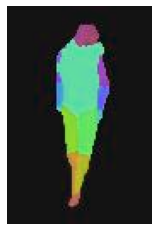

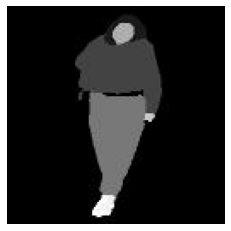

In [ ]:
p1 = r'/content/pos_test/0.jpg'
img1= cv2.imread(p1)
plot(img1)
p2 = r'/content/seg_test/0.jpg'
img2= cv2.imread(p2)
plot(img2)

In [ ]:
img1 = load_image(p1)
img2 = load_image(p2)
print(img1.shape)
print(img2.shape)
img1 = np.expand_dims(img1, axis = 0)
img2 = np.expand_dims(img2, axis = 0)
result = model.predict([img1, img2])
# result = np.resize(result, (128,128,3))

(128, 128, 3)
(128, 128, 3)


In [ ]:
result.shape

(1, 128, 128, 3)

In [ ]:
result = np.squeeze(result)

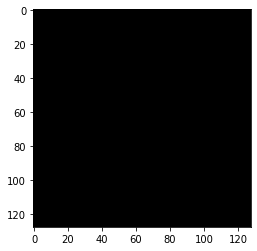

In [ ]:
plt.imshow(result)